## Strehl Ratio Calculation

### Grace E. Chesmore

January 21, 2022

This notebook explains the procedure for calculating the **Strehl ratio** of a beam.  This example is tailored for radio holograph-astronomy.  Let's consider a point-spread function.  We will use the expression for an Airy pattern, with aperture diameter $D$, at wavelength $\lambda$ [[1](https://en.wikipedia.org/wiki/Airy_disk)].

$$I(\theta) = I_0 \bigg ( \frac{2J_1(\pi D \sin(\theta)/\lambda)}{\pi D \sin(\theta)/\lambda)} \bigg ) ^2$$

As this is applied to radio-astronomy, we consider the case of a diameter $D=5.5m$ (the opening aperture of our telescope), a wavelength of $\lambda = 2mm$ (the frequency of the incoming light), and we will look at the beam out to an angle of $\theta = 25\,\text{arcmin}$.  A second airy disc is shown with some noise, which we will use to study the effects of noise on optical performance.

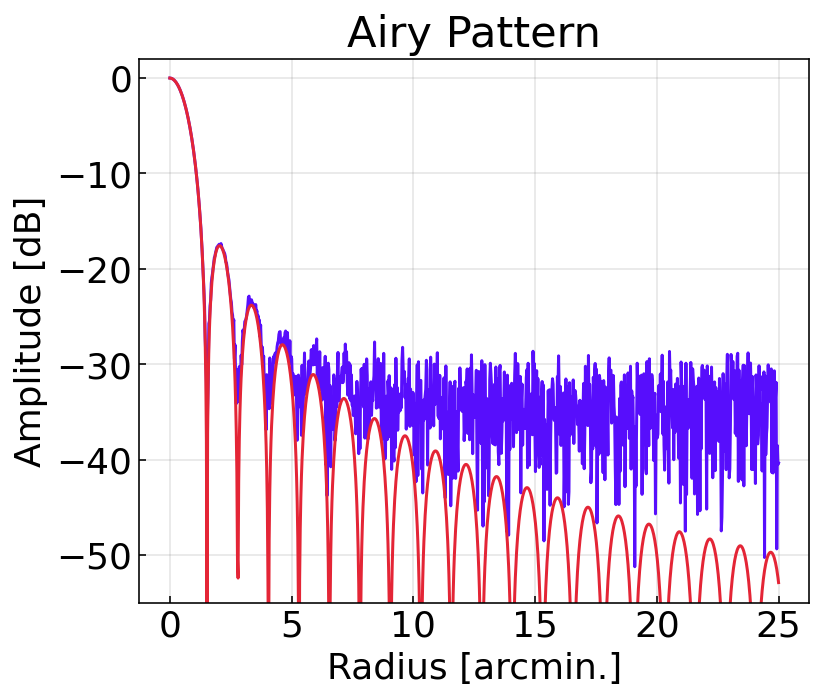

In [121]:
import numpy as np
from scipy.special import jv
from scipy import integrate,interpolate
import matplotlib
import matplotlib.pyplot as plt
import optic_funcs as of
matplotlib.rcParams["font.size"] = 18
matplotlib.rcParams.update({"axes.grid" : True, "grid.color": "grey", "grid.alpha": .2, 'xtick.direction':'in','ytick.direction':'in'})

def psf(theta_x, diameter_mm, lambda_mm):
    x = np.pi * diameter_mm * np.sin(theta_x)/lambda_mm
    I = (2 * jv(1, x)/x)**2
    return I

diameters = 1e3 * np.array([5.5]) # Diameter of aperture of LAT [mm]
THETA_MAX_ARCMIN = 25
theta_arcmin = np.linspace(0, THETA_MAX_ARCMIN, 1000); theta_arcmin[0]=1e-5
theta_rad = np.deg2rad(theta_arcmin/60.)
LAMBDA_MM = 2

# An ideal PSF
I_ideal = psf(theta_rad, diameters[0], LAMBDA_MM)

# Add noise to PSF
noise = abs(np.random.normal(0,1,len(theta_rad)))*5e-4
I_test = psf(theta_rad, diameters[0], LAMBDA_MM) + noise

fig,axes = plt.subplots(1,1,figsize = (6,5))
axes.plot(of.rad2arcmin(theta_rad),10*np.log10(I_test),color = '#570efc')
axes.plot(of.rad2arcmin(theta_rad),10*np.log10(I_ideal),color = '#e42536')
axes.set_title("Airy Pattern")
axes.set_ylabel("Amplitude [dB]")
axes.set_xlabel("Radius [arcmin.]")
axes.set_ylim(-55,2)
plt.show()

We now need to **gain-normalize** the beam.  Gain quantifies the directional power of an antenna.  First, compute the solid angle of the beam, which takes into account the directional power distribution of the beam:
$$ \Omega = 2\pi \int_{\theta_{min}}^{\theta_{max}}I(\theta)\sin(\theta)d\theta$$
We then normalize the beam with this solid angle, and our beam $I_G(\theta)$ is now in units of dBi (decibels over isotropic), rather than the previously used dB.  This is an important step because we will compare the maximum gain of our beam to that of a perfect Airy disc to get the final Strehl ratio. 
$$ I_G(\theta) = \frac{4\pi}{\Omega}I(\theta)$$

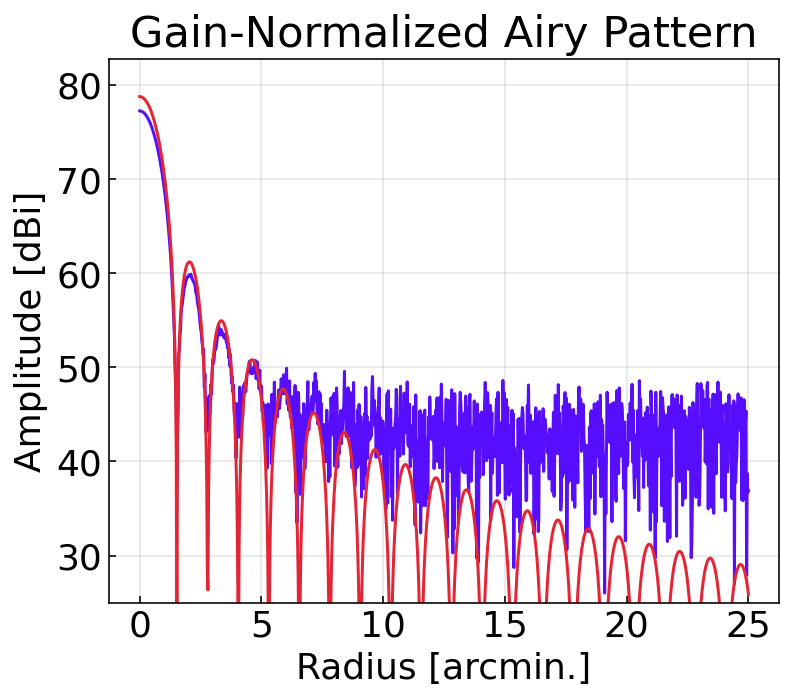

In [122]:
def integrand(x,lambda_mm):
    integ = psf(x,
             diameter_mm=diameters[0],
             lambda_mm=lambda_mm)*np.sin(x)
    return integ

p_i = np.min(theta_rad); p_f = np.max(theta_rad)
omega_int = integrate.quad(integrand, p_i, p_f,args = (2))
Omega = 2*np.pi*omega_int[0]
I_gn = (4*np.pi/Omega)*I_ideal

integrand_test = interpolate.interp1d(theta_rad,I_test*np.sin(theta_rad))
omega_int = integrate.quad(integrand_test, p_i, p_f)
Omega = 2*np.pi*omega_int[0]
I_gn_test = (4*np.pi/Omega)*I_test

# Plot the gain-normalized beams
fig,axes = plt.subplots(1,1,figsize = (6,5))
axes.plot(of.rad2arcmin(theta_rad),10*np.log10(I_gn_test),color = '#570efc')
axes.plot(of.rad2arcmin(theta_rad),10*np.log10(I_gn),color = '#e42536')
axes.set_title("Gain-Normalized Airy Pattern")
axes.set_ylabel("Amplitude [dBi]")
axes.set_xlabel("Radius [arcmin.]")
axes.set_ylim(25,np.max(10*np.log10(I_gn))+4)
plt.show()

The strehl ratio quantifies the quality of an optical system.  Here, we will find the strehl ratio of our noisy Airy disc.  A strehl ratio of $>0.8$ means the system "diffraction limited", (i.e. the resolution of the beam is at the ideal theoretical limit defined by the design of the instrument).

We have already found the gain-normalized beams.  Then, the strehl ratio is just the ratio of the peak gains (in dB scale):
$$S = \frac{10\log_{10}(I_{\text{test}})}{10\log_{10}(I_{\text{ideal}})}$$

In [125]:
strehl = np.max(I_gn_test)/np.max(I_gn)
print("Strehl Ratio: %.2f" %strehl)

Strehl Ratio: 0.71
